In [1]:
from sympy import *
import numpy as np
import pandas as pd
from copy import copy,deepcopy
import random
import matplotlib.pyplot as plt
import sys

In [217]:
def plotCA(data,size=(20,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(data,plt.cm.Greys)
    plt.ylabel("steps",fontsize="large")
    for i in range(len(data)):
        for j in range(len(data[i])):
            c = "w"
            if data[i][j] <= 2:
                c = "black"
            text = ax.text(j, i, data[i][j],
                           ha="center", va="center", color=c,fontsize="large")
    plt.show()

def cpAp(e,lst):
    a = np.append(e,lst)
    return a

def aptitud(pos,neg,notapt,removedPos,removedNeg):
    pos_values = {}
    neg_values = {}
    onlykeys = {x[0] for x in notapt}
    jstr = [str(j) for j in range(len(pos[0]))]
    for s in jstr:
        pos_values[str(s)+",1"] = 0
        pos_values[str(s)+",0"] = 0
        neg_values[str(s)+",1"] = 0
        neg_values[str(s)+",0"] = 0
    
    for i in range(len(pos)):
        if i not in removedPos:
            for j,s in enumerate(jstr):
                if pos[i][j] == 1:
                    key = s+",1"
                else:
                    key = s+",0"
                if key not in onlykeys:
                    pos_values[key] += 1
    for i in range(len(neg)):
        if i not in removedNeg:
            for j,s in enumerate(jstr):
                if neg[i][j] == 1:
                    key = s+",1"
                else:
                    key = s+",0"
                if key not in onlykeys:
                    neg_values[key] += 1
    res = []
    for key in pos_values:
        if neg_values[key] == 0 and pos_values[key] > 0:
            res.append([key,1000*pos_values[key]])
        elif neg_values[key] > 0:
            res.append([key,pos_values[key]/neg_values[key]])
            
    res.sort(key=lambda x: x[1],reverse=True)
    mx = max(res, key=lambda x: x[1])
    res = list(filter(lambda x: x[1] == mx[1],res))
    return res

def removeBest(pos,key,removedPos):
    key = key.split(",")
    index = int(key[0])
    value = int(key[1])
    for i in range(len(pos)):
        if i not in removedPos:
            if pos[i][index] == value:
                removedPos[i] = True

def removeNeg(neg,t,removedNeg):
    newneg = []
    for i in range(len(neg)):
        if i not in removedNeg:
            add = False
            for j in range(len(t)):
                key = t[j]
                key = key.split(",")
                index = int(key[0])
                value = int(key[1])
                if neg[i][index] == value:
                    add = True
                    break
            if not add:
                removedNeg[i] = True

def ocat(data,m):
    neg = data["neg"]
    pos = data["pos"]
    C = []
    removedNeg = {}
    while len(neg) > len(removedNeg):
        t = []
        removedPos = {}
        notapt = []
        while len(pos) > len(removedPos):
            apt = aptitud(pos,neg,notapt,removedPos,removedNeg)
            if m >= len(apt):
                notapt = []
            else:
                notapt = apt[m:]
                apt = apt[:m]
            if len(apt) > 0:
                best = apt[random.randint(0,len(apt)-1)]
                t.append(best[0])
                removeBest(pos,best[0],removedPos)
        C.append(t)
        removeNeg(neg,t,removedNeg)
    return C

def dictToMat(dic):
    matrix = []
    for key in dic:
        for key2 in dic[key]:
            temp = copy(dic[key][key2])
            temp.append(key)
            matrix.append(temp)
    return matrix

def getDomain(data):
    #encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
    domain = {}
    for row in data:
        for j,col in enumerate(row):
            if j not in domain:
                domain[j] = []
            if col not in domain[j]:
                domain[j].append(col)
    for key in domain:
        domain[key].sort()
    return domain

def binarize(data):
    #binarizamos los subproblemas de aprendizaje
    binarizedMatrix = []
    for row in data:
        rtemp = []
        for j,col in enumerate(row):
            if j < len(row)-1:
                for val in domain[j]:
                    if col >= val:
                        rtemp.append(1)
                    else:
                        rtemp.append(0)
            else:
                rtemp.append(col)
        binarizedMatrix.append(rtemp)
    return binarizedMatrix

def getPosNeg(domain,binarized):
    # obtenemos los ejemplos positivos y negativos para el atributo x[1] de los subproblemas
    keys = list(domain.keys())
    pos_neg = {}
    pos = {}
    for row in binarized:
        for val in domain[keys[-1]]:
            if val not in pos_neg:
                pos_neg[val] = {"pos":[],"neg":[]}
            if val not in pos:
                pos[val] = {}
            temp = "".join(map(str,row[:-1]))
            if val == row[-1]:
                if temp not in pos[val]:
                    pos_neg[val]["pos"].append(row[:-1])
                    pos[val][temp] = 0 
            else:
                if temp not in pos[val]:
                    pos_neg[val]["neg"].append(row[:-1])
                    pos[val][temp] = 0 
    return pos_neg

def getRules(posNeg,m):
    rules = {}
    for key in posNeg:
        if key not in rules:
            rules[key] = {}
        if len(posNeg[key]["pos"]) > 0 and len(posNeg[key]["neg"]) > 0:
            print("learning op ",key)
            rules[key] = ocat(posNeg[key],m)
    return rules

def binarizedToDomain(rules,domain):
    keys = list(domain.keys())
    oRules = {}
    for cls in rules:
        if cls not in oRules:
            oRules[cls] = {}
        prop = []
        for clause in rules[cls]:
            expr = []
            for term in clause:
                col = 0
                ind = int(term.split(",")[0])
                val = int(term.split(",")[1])
                bottom = 0
                for key in keys:
                    if ind >= bottom and ind <= (bottom + len(domain[key])):
                        col = key
                        ind -= bottom
                        break
                    bottom += len(domain[key])
                relational = (">=" if val== 1 else "<")
                t = "A[{}] {} {}".format(col,relational,domain[col][ind])
                expr.append(t)
            prop.append("({})".format(" or ".join(expr)))
        oRules[cls] = " and ".join(prop)
    return oRules

def getNeighbors(dataframe,r):
    #creamos un problema de aprendizaje para cada celda
    neighbors = {}
    for i,row in dataframe.iterrows():
        for j in range(len(dataframe.columns)):
            if j not in neighbors:
                neighbors[j] = []
            temp = []
            for x in range(1,(r+1)):
                if (j-x) < 0:
                    temp.append(0)
                else:
                    temp.append(row[j-x])
            temp.append(row[j])
            for x in range(1,(r+1)):
                if (j+x) >= len(dataframe.columns):
                    temp.append(0)
                else:
                    temp.append(row[j+x])
            neighbors[j].append(temp)
    return neighbors

def getClassState(neighbors):
    problem = {}
    for col in neighbors:
        for row in range(1,len(neighbors[col])):
            icenter = floor(len(neighbors[col][row])/2)
            if neighbors[col][row][icenter] not in problem:
                problem[neighbors[col][row][icenter]] = {}
            k = ",".join(map(str,neighbors[col][row-1]))
            if k not in problem[neighbors[col][row][icenter]]:
                problem[neighbors[col][row][icenter]][k] = neighbors[col][row-1]
    return problem

In [3]:
def testRulesOneDimension(initConfig,r,iterations,rules):
    appliedRules = {}
    evolution = [] 
    curr = copy(initConfig)
    evolution.append(curr)
    for step in range(iterations):
        if step not in appliedRules:
            appliedRules[step] = {}
        newCurr = copy(curr)
        for i,cell in enumerate(curr):
            if i not in appliedRules[step]:
                appliedRules[step][i] = []
            for j,op in enumerate(rules):
                A = []
                for x in range(1,(r+1)):
                    if (i-x) < 0:
                        A.append(0)
                    else:
                        A.append(curr[i-x])
                A.append(curr[i])
                for x in range(1,(r+1)):
                    if (i+x) >= len(curr):
                        A.append(0)
                    else:
                        A.append(curr[i+x])
                if eval(rules[op]):
                    newCurr[i] = op
                    appliedRules[step][i].append(op)
        curr = newCurr
        evolution.append(curr)
    return {"history":evolution,"appliedRules":appliedRules}                      

<img src="images/squaringCA.png"/>

Para cada uno de los atributos encontrar su funcion de trancision local
## cargamos el dataset del automata celular que calcula 2^2

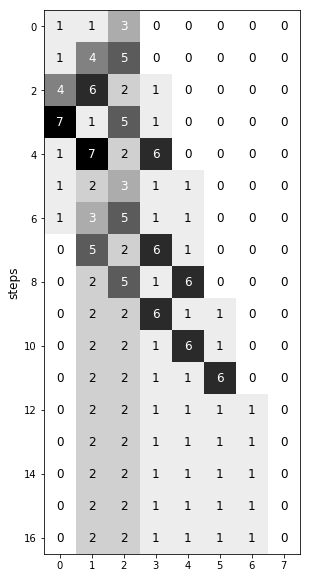

In [172]:
dataframe = pd.read_csv("data/2_square.csv")
plotCA(dataframe.values)

### Eliminamos las filas redundantes

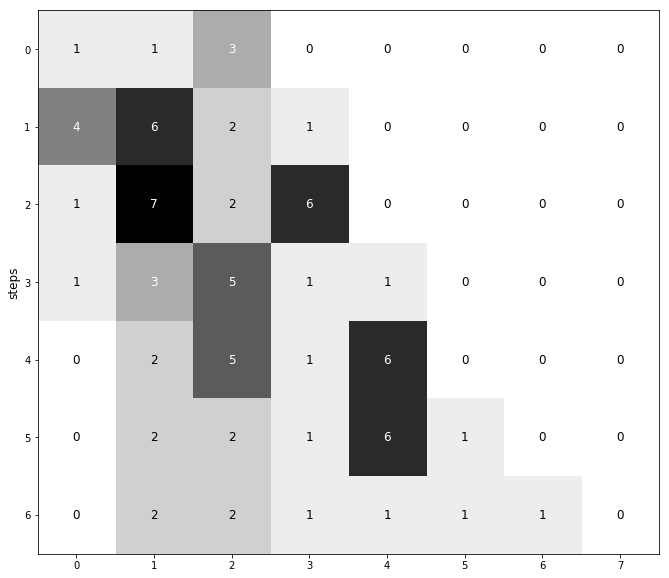

In [173]:
dataframe = dataframe.iloc[np.tile([True,False], 7),:]
plotCA(dataframe.values,(15,10))

## Set the radious of the neighborhood

In [218]:
radious = 1

In [219]:
neighbors = getNeighbors(dataframe,radious)

In [220]:
problem = getClassState(neighbors)

In [221]:
matrix = dictToMat(problem)
matrix

[[0, 1, 1, 4],
 [0, 4, 6, 1],
 [0, 1, 7, 1],
 [3, 0, 0, 1],
 [2, 6, 0, 1],
 [5, 1, 1, 1],
 [5, 1, 6, 1],
 [2, 1, 6, 1],
 [6, 0, 0, 1],
 [1, 6, 1, 1],
 [6, 1, 0, 1],
 [1, 0, 0, 1],
 [0, 1, 3, 0],
 [0, 0, 2, 0],
 [0, 0, 0, 0],
 [1, 0, 0, 0],
 [1, 1, 3, 6],
 [2, 1, 0, 6],
 [1, 1, 0, 6],
 [1, 6, 0, 6],
 [4, 6, 2, 7],
 [1, 7, 2, 3],
 [1, 3, 5, 2],
 [0, 2, 5, 2],
 [0, 2, 2, 2],
 [1, 3, 0, 2],
 [6, 2, 1, 2],
 [2, 5, 1, 2],
 [2, 2, 1, 2],
 [7, 2, 6, 5],
 [3, 5, 1, 5]]

In [222]:
domain = getDomain(matrix)

In [223]:
binarized = binarize(matrix)

In [224]:
posNeg = getPosNeg(domain,binarized)
print(posNeg[1]["pos"],posNeg[1]["neg"])

[[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]] [[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [1, 

In [225]:
rules = getRules(posNeg,10)

learning op  0
learning op  1
learning op  2
learning op  3
learning op  4
learning op  5
learning op  6
learning op  7


In [226]:
dRules = binarizedToDomain(rules,domain)

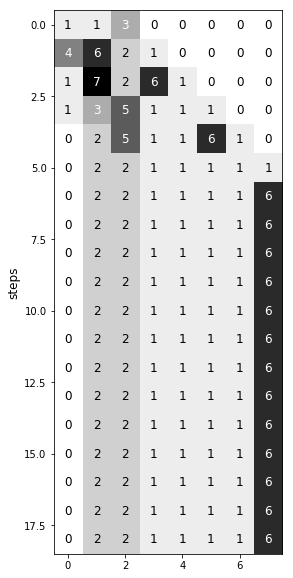

{0: '(A[1] < 1 or A[0] < 1) and (A[1] < 1 or A[2] >= 3) and (A[2] < 5) and (A[0] < 1)',
 1: '(A[2] >= 7 or A[2] >= 6 or A[1] < 1 or A[0] >= 5 or A[1] >= 6) and (A[2] >= 7 or A[1] < 2 or A[2] >= 5 or A[1] >= 6) and (A[2] >= 7 or A[0] >= 5 or A[2] >= 3 or A[2] < 2) and (A[2] >= 7 or A[1] < 2 or A[1] >= 3) and (A[0] >= 2 or A[2] >= 1 or A[1] < 5) and (A[0] >= 1 or A[2] >= 2)',
 2: '(A[1] >= 2) and (A[1] < 4 or A[1] < 6) and (A[2] < 1 or A[2] < 6) and (A[1] < 5 or A[0] < 3)',
 3: '(A[1] >= 7)',
 4: '(A[0] < 1) and (A[2] < 2) and (A[1] >= 1)',
 5: '(A[0] >= 7 or A[1] >= 5) and (A[2] >= 5 or A[0] >= 3) and (A[1] < 6)',
 6: '(A[2] < 1 or A[2] >= 3) and (A[1] >= 6 or A[2] < 5) and (A[1] >= 1) and (A[0] < 2 or A[1] < 3) and (A[1] >= 6 or A[0] < 4) and (A[1] >= 4 or A[0] >= 2 or A[1] < 2) and (A[0] >= 1)',
 7: '(A[1] >= 6) and (A[0] >= 4)'}

In [227]:
res = testRulesOneDimension([1,1,3,0,0,0,0,0],radious,18,dRules)
plotCA(res["history"])
dRules

In [24]:
res["history"]

[[1, 1, 3, 0, 0, 0, 0, 0],
 [1, 4, 5, 0, 0, 0, 0, 0],
 [4, 6, 2, 1, 0, 0, 0, 0],
 [7, 1, 5, 1, 0, 0, 0, 0],
 [1, 7, 2, 6, 0, 0, 0, 0],
 [1, 2, 3, 1, 1, 0, 0, 0],
 [1, 3, 5, 1, 1, 0, 0, 0],
 [0, 5, 2, 6, 1, 0, 0, 0],
 [0, 2, 5, 1, 6, 0, 0, 0],
 [0, 2, 2, 6, 1, 1, 0, 0],
 [0, 2, 2, 1, 6, 1, 0, 0],
 [0, 2, 2, 1, 1, 6, 0, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0]]

## Simplificacion

In [278]:
keys = list(domain.keys())
oRules = {}
for cls in rules:
    if cls not in oRules:
        oRules[cls] = {}
    prop = []
    for clause in rules[cls]:
        expr = {}
        for term in clause:
            col = 0
            ind = int(term.split(",")[0])
            val = int(term.split(",")[1])
            bottom = 0
            for key in keys:
                if ind >= bottom and ind <= (bottom + len(domain[key])):
                    col = key
                    ind -= bottom
                    break
                bottom += len(domain[key])
            relational = (">=" if val== 1 else "<")
            if col not in expr:
                expr[col] = {}
            if relational not in expr[col]:
                expr[col][relational] = None
            if val == 1:
                if expr[col][relational] == None:
                    expr[col][relational] = sys.maxsize
                expr[col][relational] = min(expr[col][relational],domain[col][ind])
            else:
                if expr[col][relational] == None:
                    expr[col][relational] = -sys.maxsize
                expr[col][relational] = max(expr[col][relational],domain[col][ind])
        expr2 = []
        for col in expr:
            if len(expr[col]) == 2:
                if expr[col][">="]-1 == expr[col]["<"]:
                    expr[col]["!="] = expr[col]["<"]
                    del expr[col][">="]
                    del expr[col]["<"]
        for col in expr:
            for rel in expr[col]:
                t = "A{} {} {}".format(col,rel,expr[col][rel])
                expr2.append(t)
        prop.append("({})".format(" or ".join(expr2)))
    oRules[cls] = " and ".join(prop)
oRules

{0: '(A1 < 4) and (A1 < 2) and (A1 < 1 or A0 < 1) and (A0 < 1) and (A2 < 5) and (A1 < 1 or A2 >= 2)',
 1: '(A1 < 5 or A0 < 2 or A2 < 1) and (A2 < 6 or A0 < 4 or A1 < 2) and (A2 < 1 or A2 >= 5 or A1 >= 4 or A0 >= 4) and (A0 < 5 or A2 < 1 or A2 >= 6 or A1 < 2) and (A1 < 3 or A1 >= 6 or A0 >= 5 or A0 < 1) and (A2 < 2 or A2 >= 6 or A1 < 2) and (A1 < 1 or A0 >= 2 or A2 >= 1) and (A0 != 2 or A2 >= 3 or A1 >= 3) and (A0 >= 1 or A2 >= 2)',
 2: '(A1 < 5 or A0 < 3) and (A0 < 4 or A2 < 6) and (A1 < 6) and (A0 >= 2 or A1 >= 2) and (A2 >= 1 or A1 >= 3) and (A1 >= 2) and (A2 < 6 or A1 < 3)',
 3: '(A1 >= 7)',
 4: '(A1 < 3) and (A0 < 4) and (A0 < 2) and (A1 < 2) and (A2 >= 1) and (A0 < 1) and (A1 >= 1) and (A2 < 3)',
 5: '(A1 >= 4 or A0 >= 6) and (A0 >= 3) and (A1 >= 5 or A2 >= 3) and (A1 < 6)',
 6: '(A1 >= 6 or A1 < 3) and (A2 < 1 or A0 < 4) and (A1 >= 6 or A0 < 2 or A2 < 1) and (A2 < 1 or A2 >= 3) and (A1 >= 6 or A2 < 1 or A0 >= 1) and (A0 >= 1) and (A1 >= 1) and (A1 >= 4 or A0 < 4) and (A0 < 2 or A

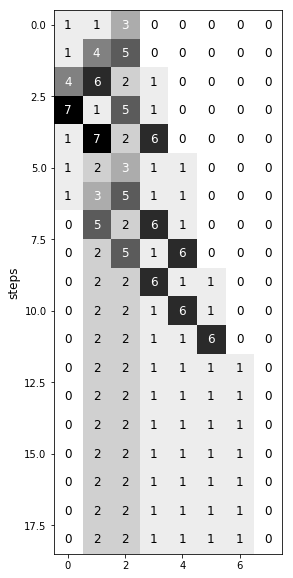

In [62]:
res = testRulesOneDimension([1,1,3,0,0,0,0,0],18,oRules)
plotCA(res["history"])

In [63]:
literals = {}
literalsInv = {}
count = 0
for key in oRules:
    sel = oRules[key].replace("(","").replace(")","").replace("or",",").replace("and",",").replace(" ","").split(",")
    for el in sel:
        if el not in literals:
            literals[el] = "X{}".format(count)
            literalsInv["X{}".format(count)] = el
            count += 1
literals    

{'A0<2': 'X0',
 'A2<4': 'X1',
 'A1<2': 'X2',
 'A0<5': 'X3',
 'A1<1': 'X4',
 'A0<1': 'X5',
 'A2>=3': 'X6',
 'A0<4': 'X7',
 'A1>=6': 'X8',
 'A1<7': 'X9',
 'A2<2': 'X10',
 'A0<6': 'X11',
 'A1>=1': 'X12',
 'A0>=2': 'X13',
 'A0>=5': 'X14',
 'A2<3': 'X15',
 'A2>=5': 'X16',
 'A1!=3': 'X17',
 'A2!=3': 'X18',
 'A2<5': 'X19',
 'A1<4': 'X20',
 'A1>=2': 'X21',
 'A1>=4': 'X22',
 'A2>=2': 'X23',
 'A1<6': 'X24',
 'A0<3': 'X25',
 'A0>=7': 'X26',
 'A2>=1': 'X27',
 'A1<3': 'X28',
 'A0>=1': 'X29',
 'A2>=6': 'X30',
 'A2>=4': 'X31',
 'A2<7': 'X32',
 'A0<7': 'X33',
 'A0>=3': 'X34',
 'A1>=3': 'X35',
 'A1<5': 'X36',
 'A0>=4': 'X37',
 'A0>=6': 'X38',
 'A0!=2': 'X39'}

In [64]:
clausulesWLiterals = {}
for key in oRules:
    clsstr = oRules[key].replace(" ","").replace("or"," or ").replace("and"," and ")
    count = 0
    for key3 in literals:
        if key3 in clsstr:
            clsstr = clsstr.replace(key3,literals[key3])
            count += 1
    if key not in clausulesWLiterals:
        clausulesWLiterals[key] = {}
    clausulesWLiterals[key]=[clsstr,count]
clausulesWLiterals

{0: ['(X0 or X1) and (X2) and (X3) and (X4 or X5) and (X1 or X4) and (X4 or X6)',
  7],
 1: ['(X7 or X1) and (X2 or X8) and (X9 or X10) and (X11 or X4) and (X3 or X4) and (X12 or X13) and (X12 or X14) and (X15 or X16)',
  14],
 2: ['(X15 or X7) and (X17) and (X3) and (X18 or X13) and (X19 or X20) and (X12) and (X13 or X21 or X15) and (X13 or X22 or X23) and (X24 or X23) and (X21) and (X24 or X25)',
  14],
 3: ['(X26 or X0) and (X27) and (X28) and (X29) and (X30 or X7) and (X14 or X21)',
  9],
 4: ['(X25) and (X28) and (X2) and (X27) and (X12) and (X29 or X31) and (X23) and (X1 or X5) and (X29 or X32)',
  11],
 5: ['(X33) and (X16 or X15) and (X34 or X35) and (X30 or X36) and (X16 or X21) and (X21) and (X13 or X1 or X20)',
  11],
 6: ['(X1 or X2 or X22) and (X14 or X23) and (X2 or X11) and (X37 or X22) and (X2 or X31) and (X10 or X33) and (X29) and (X12)',
  12],
 7: ['(X38 or X7) and (X16) and (X37 or X30) and (X2 or X3) and (X39) and (X26 or X21)',
  10]}

In [67]:
simpExpr = {}
for key in clausulesWLiterals:
    strexpr = clausulesWLiterals[key][0]
    print(key)
    strexpr = strexpr.replace("or","|").replace("and","&").replace("[","").replace("]","")
    strsimp = str(simplify_logic(strexpr))
    strsimp = strsimp.replace("|","or").replace("&","and")
    if key not in simpExpr:
        simpExpr[key] = ""
    simpExpr[key] = strsimp
simpExpr

0
1
2
3
4
5
6
7


{0: 'X2 and X3 and (X0 or X1) and (X1 or X4) and (X4 or X5) and (X4 or X6)',
 1: '(X1 or X7) and (X10 or X9) and (X11 or X4) and (X12 or X13) and (X12 or X14) and (X15 or X16) and (X2 or X8) and (X3 or X4)',
 2: 'X12 and X17 and X21 and X3 and (X13 or X18) and (X15 or X7) and (X19 or X20) and (X23 or X24) and (X24 or X25) and (X13 or X15 or X21) and (X13 or X22 or X23)',
 3: 'X27 and X28 and X29 and (X0 or X26) and (X14 or X21) and (X30 or X7)',
 4: 'X12 and X2 and X23 and X25 and X27 and X28 and (X1 or X5) and (X29 or X31) and (X29 or X32)',
 5: 'X21 and X33 and (X15 or X16) and (X16 or X21) and (X30 or X36) and (X34 or X35) and (X1 or X13 or X20)',
 6: 'X12 and X29 and (X10 or X33) and (X11 or X2) and (X14 or X23) and (X2 or X31) and (X22 or X37) and (X1 or X2 or X22)',
 7: 'X16 and X39 and (X2 or X3) and (X21 or X26) and (X30 or X37) and (X38 or X7)'}

In [69]:
simpExpr2 = {}
for key in simpExpr:
    temp = simpExpr[key].replace(")"," )") + " "
    for key3 in literalsInv:
        temp = temp.replace(key3+" ",literalsInv[key3]+" ")
    if key not in simpExpr2:
        simpExpr2[key] = ""
    simpExpr2[key] = temp
simpExpr2

{0: 'A1<2 and A0<5 and (A0<2 or A2<4 ) and (A2<4 or A1<1 ) and (A1<1 or A0<1 ) and (A1<1 or A2>=3 ) ',
 1: '(A2<4 or A0<4 ) and (A2<2 or A1<7 ) and (A0<6 or A1<1 ) and (A1>=1 or A0>=2 ) and (A1>=1 or A0>=5 ) and (A2<3 or A2>=5 ) and (A1<2 or A1>=6 ) and (A0<5 or A1<1 ) ',
 2: 'A1>=1 and A1!=3 and A1>=2 and A0<5 and (A0>=2 or A2!=3 ) and (A2<3 or A0<4 ) and (A2<5 or A1<4 ) and (A2>=2 or A1<6 ) and (A1<6 or A0<3 ) and (A0>=2 or A2<3 or A1>=2 ) and (A0>=2 or A1>=4 or A2>=2 ) ',
 3: 'A2>=1 and A1<3 and A0>=1 and (A0<2 or A0>=7 ) and (A0>=5 or A1>=2 ) and (A2>=6 or A0<4 ) ',
 4: 'A1>=1 and A1<2 and A2>=2 and A0<3 and A2>=1 and A1<3 and (A2<4 or A0<1 ) and (A0>=1 or A2>=4 ) and (A0>=1 or A2<7 ) ',
 5: 'A1>=2 and A0<7 and (A2<3 or A2>=5 ) and (A2>=5 or A1>=2 ) and (A2>=6 or A1<5 ) and (A0>=3 or A1>=3 ) and (A2<4 or A0>=2 or A1<4 ) ',
 6: 'A1>=1 and A0>=1 and (A2<2 or A0<7 ) and (A0<6 or A1<2 ) and (A0>=5 or A2>=2 ) and (A1<2 or A2>=4 ) and (A1>=4 or A0>=4 ) and (A2<4 or A1<2 or A1>=4 ) ',
 7:

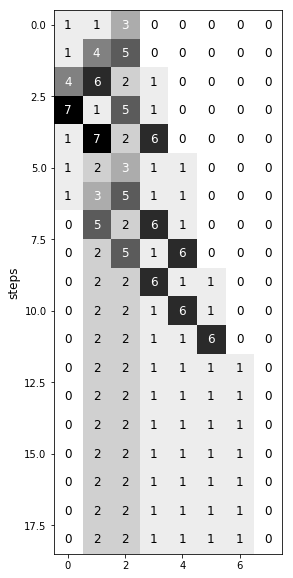

In [71]:
res = testRulesOneDimension([1,1,3,0,0,0,0,0],18,simpExpr2)
plotCA(res["history"])